# Examples of image color reduction.

In this script, we use a K-Means classifier to reduce the number of colors in a colorful image of M&Ms candies. 
The goal is to transform the RGB image into an indexed color image using a minimal colormap. 

Standard RGB images use 3 bytes to store the color information of every pixel: $R\in [0,255]$, $G\in [0,255]$, $B\in [0,255]$.
Indexed images use only 1 byte to store the color index of every pixel. They use colormaps containing 
N values of R, G and B where $N\le 256$. As a result, they require 3x less data than standard RGB images.

We use a K-means classifier with the standard euclidean distance metric. The classifier is used with a pre-defined number 
of classes where one color cluster is assigned to each class. The quality of image compression depends heavily on the 
number of colors used. Images with too many colors show no visible artefacts but only provide a small amount of data compression. 
Images with too few colors use less data but look sketchy; they are useless. 

The right number of colors depends on the cluster compactedness. Using too few clusters results in extended 
clusters in RGB space that encompass several different colors. Using too many clusters results in many small 
neighboring clusters that correspond to shades of the same local color. 

A measure of cluster compactedness is the average cluster inertia 

<blockquote>  $I = \sum_{t=1}^{N}\sum_{i=1}^{K} b_{i}^{t} |\bf{x}^{t} -\bf{\mu}_{i}|^{2}$ </blockquote>


with 

<blockquote>  the observations:   $\bf{x}^{t}$ </blockquote> 

<blockquote>  the K class centers:   $\bf{\mu_{i}}$  </blockquote> 

<blockquote>  the class indicators of the observations: 
<blockquote> 
$b_{i}^{t}=\left\{
    \begin{array}{ll}
      1, & \mbox{if $\bf{x}^{t} \in \cal{C_{i}}$}.\\
      0, & \mbox{otherwise}.
    \end{array}
  \right.$                                            
</blockquote> 
</blockquote> 
    
We use a scree plot between the average cluster inertia and the number of clusters to determine the optimal number of clusters. 
    
M&Ms come in about 6 different colors, not including holiday colors. The colors currently in use are: red, 
yellow, brown, orange, green and blue (Reference: https://en.wikipedia.org/wiki/M%26M%27s). Hence, we should 
expect to find an optimal number of clusters around 6 or slightly more if new M&Ms colors appear in the picture.

In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

%matplotlib inline

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage import color
from skimage import io
import random
import wget

import seaborn as sns
sns.set(color_codes=True)

# Used for reproductibility of the results
np.random.seed(43)

Automatically created module for IPython interactive environment


## Read the image of M&Ms candies

The image contains 8.4 million pixels. Let us reduce the image shape by a factor of four and show the result. 
This is the image that will be used for color compression.

In [2]:
image_url = 'https://www.acouplefortheroad.com/wp-content/uploads/2017/07/8505451342_63c028b7e4_k.jpg'
fileName = wget.download(image_url)
rgb = io.imread(fileName)

rgb = resize(rgb, (rgb.shape[0] // 4, rgb.shape[1] // 4), anti_aliasing=True)

100% [............................................................................] 232169 / 232169

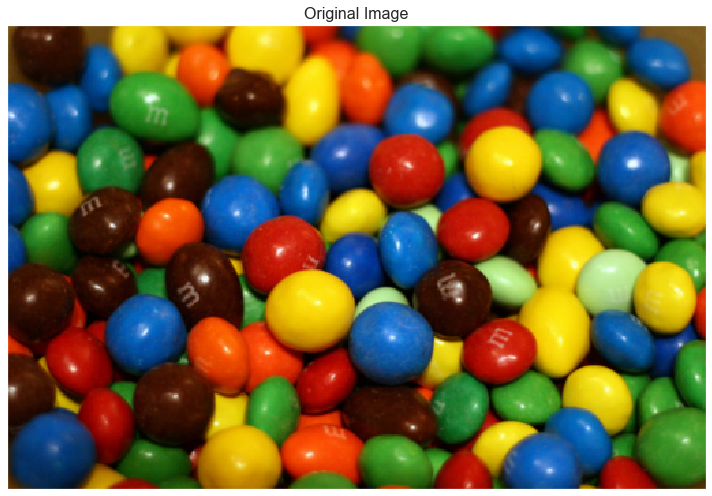

In [3]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.imshow(rgb)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_title('Original Image', fontsize=16)
plt.tight_layout()
plt.show()

## Generate the feature matrix $X=[R, G, B]$
Each column is a color channel (a feature) and each line is a pixel (an observation)

In [4]:
r = rgb[:,:,0].reshape(-1,1)
g = rgb[:,:,1].reshape(-1,1)
b = rgb[:,:,2].reshape(-1,1)

X = np.concatenate((r, g, b), axis=1)


## Select 5000 random observations from the feature matrix  

We use a smaller set of observations to train K-means classifiers.

In [5]:
# Total number of observations
N = X.shape[0]

Npts = 5000

indx = random.sample(range(0, N), Npts)
X_s = X[indx,:]

## Find the optimal number of clusters using a scree plot

This approach is reminiscent of the one used in Principal Component Analysis to identify the optimal number of 
principal components to keep. PCA uses a scree plot showing eigenvalues $\lambda$ $\it{versus}$ $N_{components}$. 
The optimal number of components is found by locating the "knee" in the curve. The same approach is used here to identify 
the optimal of clusters. 


In [6]:
N_clusters = 30
inertia = np.zeros(N_clusters)

for n in range(N_clusters):
    kmeans = KMeans(n_clusters=n+1, random_state=0).fit(X_s)
    inertia[n] = kmeans.inertia_
    

The next figure shows a scree plot of the average cluster inertia $versus$ the number of clusters. There is a break 
in the curve around $N_{clusters}=6$, where the 'knee' of the curve is located. Beyond that point, the rate of change 
in average inertia slowly decreases with the number of clusters. Adding more clusters, adds more colors in a
color-compressed image but many of those colors are various shades or mixes of the first six colors. 

This agrees with the approximate number of candy colors used: blue, brown, green, orange, red, 
and yellow.

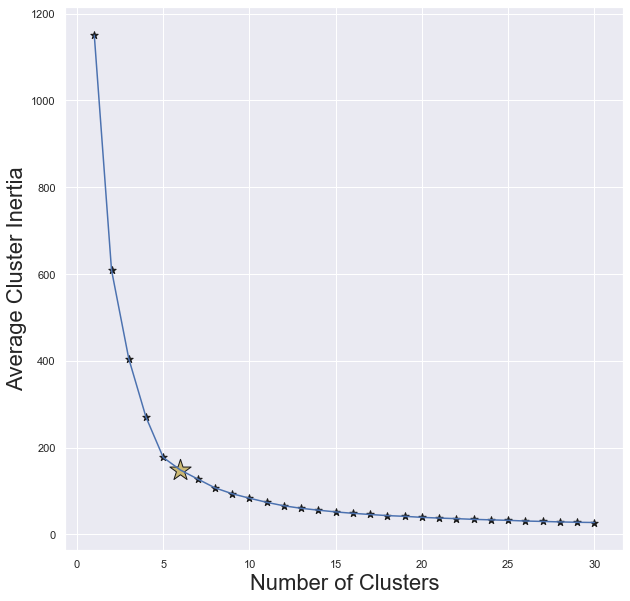

In [7]:
n = np.arange(1,N_clusters+1)
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(n, inertia)
ax.scatter(n,inertia, c = 'k', marker = '*', s=60)
ax.scatter(n[5],inertia[5], c = 'y', marker = '*', edgecolors='k', s=500)
ax.set_xlabel('Number of Clusters', fontsize=22)
ax.set_ylabel('Average Cluster Inertia', fontsize=22)

plt.savefig('14.1.1_Scree_plot_M&Ms_colors.png')
plt.savefig('14.1.1_Scree_plot_M&Ms_colors.pdf')

## Function for image-color reduction and displaying

Let us define a useful fonction for comparing results with different numbers of clusters/colors.

In [8]:
def display_color_reduction(X, rgb, n, ax=None):
    
    # K-means classification
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
    
    # Pixel labels
    y = kmeans.labels_
    y = y.reshape((rgb.shape[0], rgb.shape[1]))
    
    # Cluster centers in (R, G, B) space
    centers = kmeans.cluster_centers_
    
    # Define a colormap using those cluster centers
    cm_bright = ListedColormap(centers)
    
    # Display the image with classified colors
    if ax is None:
        ax = plt.gca()
        
    ax.imshow(y, cmap=cm_bright)
    ax.set_title('K= %d' % (n), fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)


## Display best color-reduction results

The results for $N_{clusters}=6$ are shown below. Most of the candies are well delineated. The red and orange 
candies have the same color. Some candies have a new color, light green. Two of them are indicated by stars in 
the second panel and others can be found nearby. Hence the total number of colors is correct but 2 colors are 
confused and a new one is found! 

Better results should be obtained using the Hue-Saturation-Value (HSV) system instead of the RGB system.  

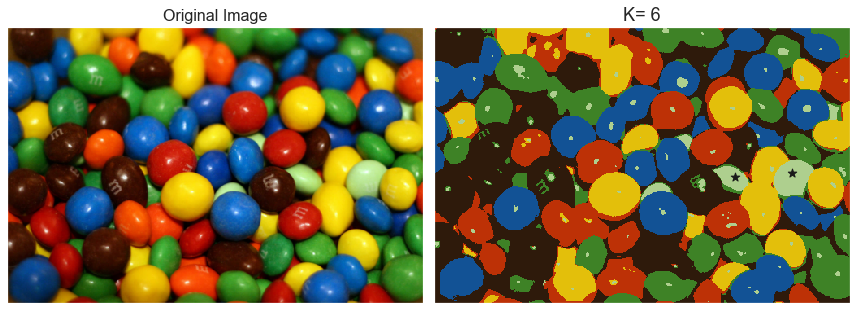

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (12,6)) 

axs[0].imshow(rgb)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].grid(False)
axs[0].set_title('Original Image', fontsize=16)

display_color_reduction(X, rgb, 6, ax=axs[1])
axs[1].scatter(370, 185, c = 'k', marker = '*', s=80)
axs[1].scatter(440, 180, c = 'k', marker = '*', s=80)
plt.tight_layout()

plt.savefig('14.1.2_Optimal_color_compression.png')
plt.savefig('14.1.2_Optimal_color_compression.pdf')

plt.show()


## Display color-reduction results using several numbers of clusters/colors

The next figure shows that all candy colors can be observed with $N_{clusters}=8$. However, the candy colors are no longer 
uniform due to shading effects. The results with 6 colors produce the most uniform color distribution in each M&Ms.

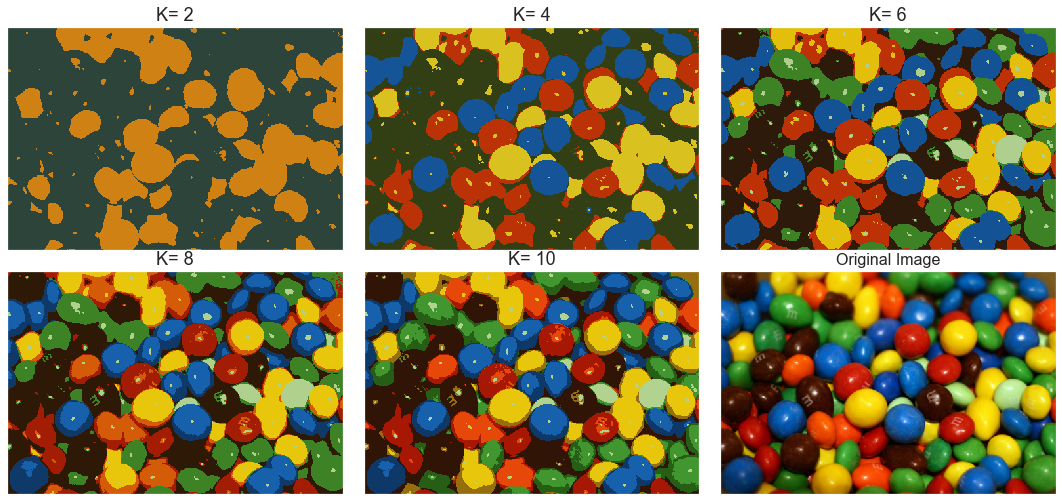

In [10]:
fig, axs = plt.subplots(2, 3, figsize = (15,7)) 

axs[1][2].imshow(rgb)
axs[1][2].set_xticks([])
axs[1][2].set_yticks([])
axs[1][2].grid(False)
axs[1][2].set_title('Original Image', fontsize=16)

display_color_reduction(X, rgb, 2, ax=axs[0][0])
display_color_reduction(X, rgb, 4, ax=axs[0][1])
display_color_reduction(X, rgb, 6, ax=axs[0][2])
display_color_reduction(X, rgb, 8, ax=axs[1][0])
display_color_reduction(X, rgb, 10, ax=axs[1][1])

plt.tight_layout()

plt.savefig('14.1.3_Various_levels_of_color_compression.png')
plt.savefig('14.1.3_Various_levels_of_color_compression.pdf')

plt.show()